<a href="https://colab.research.google.com/github/Malbasahi/A-Computationally-Efficient-Baseline-for-Detecting-AI-Generated-Code/blob/main/ML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

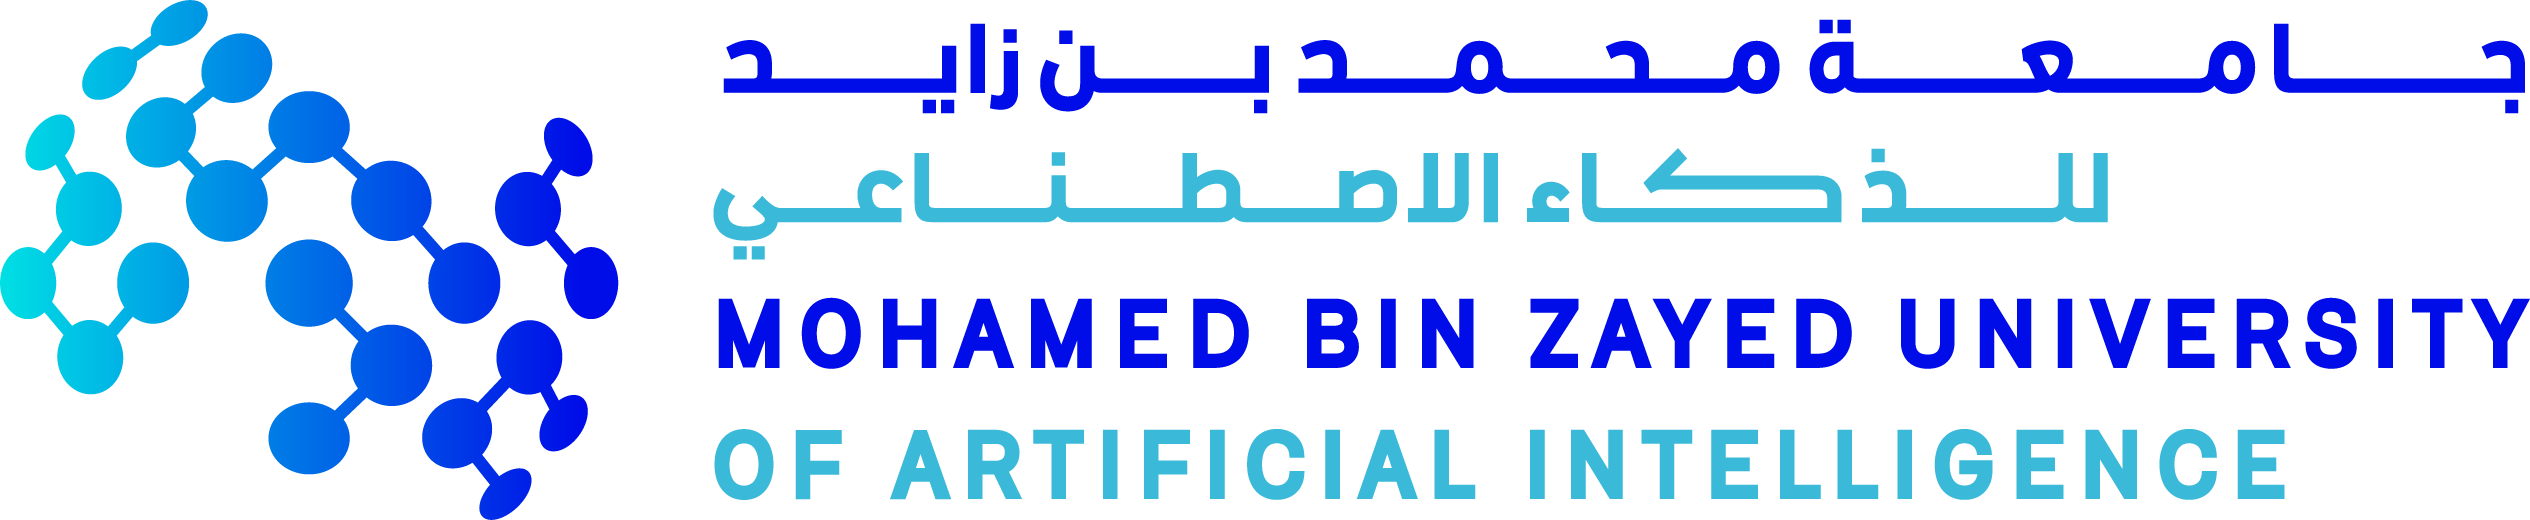

# **AI 7101 - Machine Learning with Python**
**Spring 2026**

***Course Project*** - Project 4


# **Movie Review Sentiment + Topic Discovery**
Team Memebers:
1. Marwah Ba Suhai
2. Rawda Alsamahi
3. Ayah Al-Naji



##**The goal of this project is to:**


*   Make a supervised machine learning model that can tell the difference between good and bad movie reviews.
*   Use the right metrics (F1 and ROC-AUC) and proper cross-validation to check the model.
*   Use NMF topic modeling to find topics that make sense so you can see what themes are talked about in good and bad reviews.
*   Look at model errors and find patterns in how things are misclassified.
*   Make sure that the pipeline implementation can be fully reproduced and has no leaks.







##**Section#1: Environment & Reproducibility (Owner: Ayah Al-Naji)**

Runtime: Google Colab

Random seed: 42

Reproducibility: Notebook runs top-to-bottom on a clean runtime.

Note: All preprocessing and modeling are done inside scikit-learn Pipelines to avoid leakage.








In [ ]:

#=========================Environment & Reproducibility=========================

RANDOM_STATE = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sys
import platform
import random

# Make runs reproducible (as much as possible)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Python:", sys.version)
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35
NumPy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1


##**Section#2: Data Loading (Owner: Ayah Al-Naji)**
Dataset: Stanford Large Movie Review Dataset (IMDB)
Total samples: 50,000
Split:
*   25,000 training
*   25,000 test

We preserve the original train/test split.
The test set will be evaluated only once at the end.

In [ ]:
# ========================= Extract Stanford IMDB Dataset =========================
import os
import tarfile

# Check if file exists
if os.path.exists("aclImdb_v1.tar.gz"):
    print("Found aclImdb_v1.tar.gz.")
else:
    print("File not found. Downloading...")
    !wget -q https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    print("Download complete.")

print("Extracting...")

with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
    tar.extractall()

print("Extraction complete.")

# ========================= Verify Structure =========================
print("\nTop-level files:", os.listdir(".")[:20])

print("\naclImdb exists?", os.path.exists("aclImdb"))

if os.path.exists("aclImdb"):
    print("\naclImdb contents:", os.listdir("aclImdb"))
    print("train contents:", os.listdir("aclImdb/train"))
    print("test contents:", os.listdir("aclImdb/test"))

Found aclImdb_v1.tar.gz.
Extracting...


/tmp/ipython-input-720/4129763630.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction complete.

Top-level files: ['.config', 'aclImdb', 'aclImdb_v1.tar.gz', '.ipynb_checkpoints', 'sample_data']

aclImdb exists? True

aclImdb contents: ['README', 'imdbEr.txt', 'imdb.vocab', 'train', 'test']
train contents: ['pos', 'labeledBow.feat', 'unsup', 'urls_pos.txt', 'neg', 'urls_neg.txt', 'unsupBow.feat', 'urls_unsup.txt']
test contents: ['pos', 'labeledBow.feat', 'urls_pos.txt', 'neg', 'urls_neg.txt']


In [ ]:
#=========================To verify the exact counts=========================

import os

def count_txt_files(path):
    return len([f for f in os.listdir(path) if f.endswith(".txt")])

print("Train pos:", count_txt_files("aclImdb/train/pos"))
print("Train neg:", count_txt_files("aclImdb/train/neg"))
print("Test pos:", count_txt_files("aclImdb/test/pos"))
print("Test neg:", count_txt_files("aclImdb/test/neg"))

train_total = count_txt_files("aclImdb/train/pos") + count_txt_files("aclImdb/train/neg")
test_total  = count_txt_files("aclImdb/test/pos") + count_txt_files("aclImdb/test/neg")

print("Total train:", train_total)
print("Total test:", test_total)


Train pos: 12500
Train neg: 12500
Test pos: 12500
Test neg: 12500
Total train: 25000
Total test: 25000


##**Section#3: Problem Framing (Owner: Ayah Al-Naji)**

**Decision supported:**

Classify each review as positive or negative to help a product team track user sentiment.

**User:**

Product team / analysts monitoring feedback.

**Cost of being wrong:**

1. False Positive (predict positive, actually negative): may hide unhappy feedback → missed issues.

2. False Negative (predict negative, actually positive): may exaggerate problems → unnecessary alarm.

**Success metric:**

We report F1 (balances precision/recall) and ROC-AUC (ranking quality across thresholds).
Final decision threshold will be justified using the confusion matrix and tradeoffs.

##**Section#4: Data Audit (EDA)**
###**4.1: Load the text data into Python (Owner: Ayah Al-Naji)**


*   Here we need to
      * Read all .txt files.
      * Create:
          * X_train

          * y_train

          * X_test

          * y_test


In [ ]:

# =========================Step 4.1 - Load Text Data=========================
import os

def load_reviews(folder_path, label):
    texts = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), encoding="utf-8") as f:
                texts.append(f.read())
                labels.append(label)

    return texts, labels


#=========================Load training data=========================
train_pos, y_train_pos = load_reviews("aclImdb/train/pos", 1)
train_neg, y_train_neg = load_reviews("aclImdb/train/neg", 0)

#=========================Load test data=========================
test_pos, y_test_pos = load_reviews("aclImdb/test/pos", 1)
test_neg, y_test_neg = load_reviews("aclImdb/test/neg", 0)

#=========================Combine=========================
X_train = train_pos + train_neg
y_train = y_train_pos + y_train_neg

X_test = test_pos + test_neg
y_test = y_test_pos + y_test_neg

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 25000
Test size: 25000


###**4.2: Class Balance Check(Owner: Ayah Al-Naji)**

We want to verify:
*   Are classes balanced?
*   Any skew?
*   Does train match test?

Train distribution:
label
1    12500
0    12500
Name: count, dtype: int64

Test distribution:
label
1    12500
0    12500
Name: count, dtype: int64

Train percentage:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test percentage:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


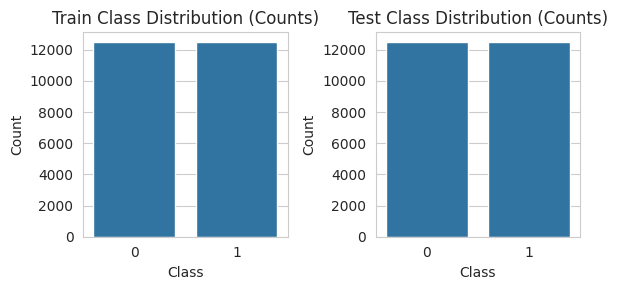

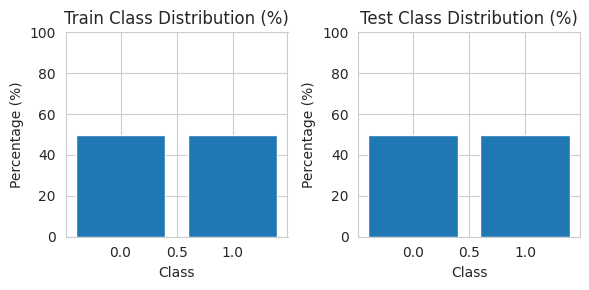

In [ ]:
#=========================Step 4.2 - Class Balance=========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X_train, y_train, X_test, y_test are already defined
# Convert to pandas for easier inspection
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df  = pd.DataFrame({"text": X_test, "label": y_test})

# Print distributions
print("Train distribution:")
print(train_df["label"].value_counts())
print("\nTest distribution:")
print(test_df["label"].value_counts())
print("\nTrain percentage:")
print(train_df["label"].value_counts(normalize=True))
print("\nTest percentage:")
print(test_df["label"].value_counts(normalize=True))

# ===== Visualizations =====
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(6, 3))

# Plot 1: Train counts
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='label', order=sorted(train_df['label'].unique()))
plt.title('Train Class Distribution (Counts)')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot 2: Test counts
plt.subplot(1, 2, 2)
sns.countplot(data=test_df, x='label', order=sorted(test_df['label'].unique()))
plt.title('Test Class Distribution (Counts)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Optional: percentage plots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
train_perc = train_df['label'].value_counts(normalize=True).sort_index() * 100
test_perc = test_df['label'].value_counts(normalize=True).sort_index() * 100

# Train percentages
axes[0].bar(train_perc.index, train_perc.values)
axes[0].set_title('Train Class Distribution (%)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(0, 100)

# Test percentages
axes[1].bar(test_perc.index, test_perc.values)
axes[1].set_title('Test Class Distribution (%)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

###**4.3: Text Length Distribution (Owner: Ayah Al-Naji)**

We are doing this because:
*   Some reviews are extremely short
*   Some are very long
*   It affects vectorization and model behavior



Average length: 233.7872
Minimum length: 10
Maximum length: 2470


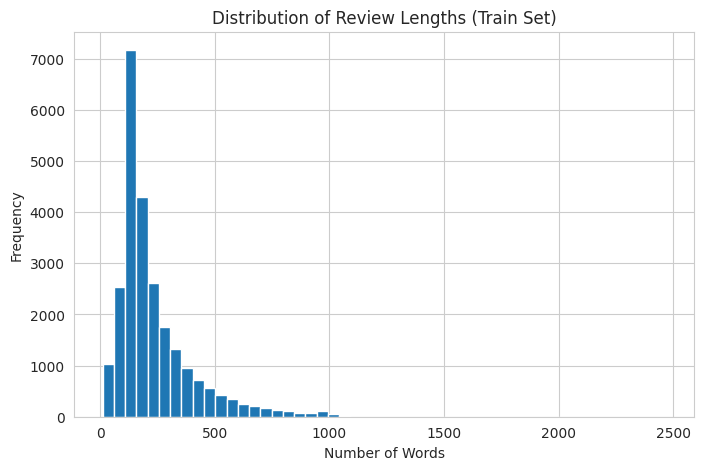

In [ ]:

#=========================Step 4.3 - Text Length Distribution=========================

import matplotlib.pyplot as plt

#=========================Compute length in number of words=========================
train_lengths = [len(text.split()) for text in X_train]

print("Average length:", sum(train_lengths) / len(train_lengths))
print("Minimum length:", min(train_lengths))
print("Maximum length:", max(train_lengths))

plt.figure(figsize=(8,5))
plt.hist(train_lengths, bins=50)
plt.title("Distribution of Review Lengths (Train Set)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


###**Observations on Review Length Distribution:**

1.   The average review is about 234 words long, indicating that most reviews contain substantial textual information.
2.   The distribution is right-skewed, which means that a small number of reviews are very long (up to 2470 words), while most reviews are between 100 and 400 words.
3. Some reviews are very short, but they still have important information in them. The minimum length of 10 words shows this.

###**Implications for Modeling:**
1. Since reviews are relatively long, bag-of-words and TF-IDF representations are appropriate, as there is enough textual signal to learn from.

2. The presence of very long reviews suggests high vocabulary diversity, so vocabulary pruning (min_df / max_df) will likely be important.

3. No manual truncation is required at this stage, as length variability can be handled naturally by vectorization.



###**4.4: Leakage Risk & Validation Protocol(Owner: Ayah Al-Naji)**
####**Leakage Prevention:**


*   We keep the official split of 25k train and 25k test.
*   The test set is never used to choose or tune a model.
*   We will only use cross-validation on the training set to tune the hyperparameters.
*   The test set will be evaluated once at the very end, after final model selection.

####**Validation Strategy**

*   We will use Stratified 5-Fold Cross-Validation on the data we use to train the model.
*   During validation, stratification keeps the classes balanced.
*   For reproducibility, the random seed is 42.


##**Section#5: Baselines**
###**5.1: Majority Class Baseline(Owner: Ayah Al-Naji)**


In [ ]:
#=========================5.1 Majority Class Baseline=========================

from sklearn.metrics import accuracy_score, f1_score

#=========================Majority class is either 0 or 1 (they are equal, so we choose 1)=========================
majority_label = 1

y_pred_majority = [majority_label] * len(y_test)

print("Accuracy:", accuracy_score(y_test, y_pred_majority))
print("F1 Score:", f1_score(y_test, y_pred_majority))


majority_label = 1

y_pred_majority = [majority_label] * len(y_train)

print("Accuracy:", accuracy_score(y_train, y_pred_majority))
print("F1 Score:", f1_score(y_train, y_pred_majority))


Accuracy: 0.5
F1 Score: 0.6666666666666666
Accuracy: 0.5
F1 Score: 0.6666666666666666


###**5.2 TF-IDF + Logistic Regression (Baseline Pipeline)(Owner: Ayah Al-Naji)**
We implement a simple baseline using:
*  TfidfVectorizer
*  LogisticRegression
*  5-fold Stratified Cross-Validation

All preprocessing is done inside a Pipeline to avoid leakage.

In [ ]:

#=========================5.2 TF-IDF + Logistic Regression Baseline=========================

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold

#=========================Define cross-validation=========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#=========================Define pipeline=========================
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

#=========================Cross-validation evaluation=========================
scores = cross_validate(
    baseline_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=["f1", "roc_auc"],
    return_train_score=False
)

print("F1 (CV mean ± std): {:.4f} ± {:.4f}".format(
    scores["test_f1"].mean(),
    scores["test_f1"].std()
))

print("ROC-AUC (CV mean ± std): {:.4f} ± {:.4f}".format(
    scores["test_roc_auc"].mean(),
    scores["test_roc_auc"].std()
))


F1 (CV mean ± std): 0.8884 ± 0.0032
ROC-AUC (CV mean ± std): 0.9554 ± 0.0015


####**Baseline Interpretation**
* The baseline TF-IDF + Logistic Regression model achieves strong performance (F1 ≈ 0.89, ROC-AUC ≈ 0.96).

* A low standard deviation across folds shows that generalization is stable.

* This shows that bag-of-words representations work well for sentiment classification on this dataset.

* Future enhancements will concentrate on feature engineering and model evaluation.

##**Section#6: Feature Engineering Experiments**
###**6.1: N-grams Experiment (1–1 vs 1–2 vs 1–3)(Owner: Ayah Al-Naji)**
We test whether adding bigrams/trigrams improves sentiment classification by comparing:

* unigrams only (1,1)

* unigrams + bigrams (1,2)

* unigrams + bigrams + trigrams (1,3)

All experiments use a leakage-free Pipeline with cross-validation.

Best F1: 0.8883720559934041
Best params: {'tfidf__ngram_range': (1, 1)}
  param_tfidf__ngram_range  mean_test_score  std_test_score  rank_test_score
0                   (1, 1)         0.888372        0.003242                1
1                   (1, 2)         0.887851        0.002701                2
2                   (1, 3)         0.879816        0.003509                3


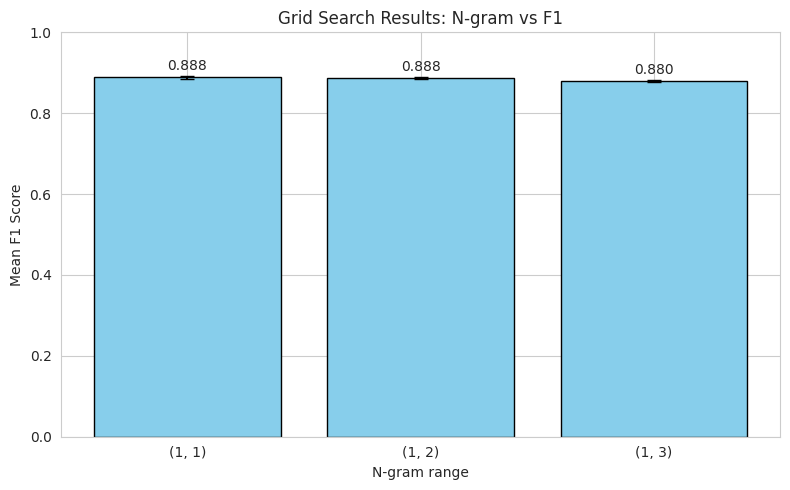

In [ ]:
#=========================6.1 N-grams experiment (LogReg)=========================

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_ngrams = {
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)]
}

grid_ngrams = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_ngrams,
    cv=cv,                      # uses StratifiedKFold from earlier
    scoring="f1",
    n_jobs=-1,
    return_train_score=False
)

grid_ngrams.fit(X_train, y_train)

print("Best F1:", grid_ngrams.best_score_)
print("Best params:", grid_ngrams.best_params_)

#=========================Show all results in a small table=========================
results_ngrams = pd.DataFrame(grid_ngrams.cv_results_)[
    ["param_tfidf__ngram_range", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score")

print(results_ngrams)

#=========================Visual comparison=========================
# Extract data for plotting
ngram_labels = [str(r) for r in results_ngrams["param_tfidf__ngram_range"]]
mean_scores = results_ngrams["mean_test_score"]
std_scores = results_ngrams["std_test_score"]

plt.figure(figsize=(8, 5))
x_pos = np.arange(len(ngram_labels))
bars = plt.bar(x_pos, mean_scores, yerr=std_scores, capsize=5, color='skyblue', edgecolor='black')
plt.xticks(x_pos, ngram_labels)
plt.xlabel("N-gram range")
plt.ylabel("Mean F1 Score")
plt.title("Grid Search Results: N-gram vs F1")
plt.ylim(0, 1)  # F1 is between 0 and 1

# Add value labels on bars
for bar, score in zip(bars, mean_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

####**Observation (N-grams):**

* Unigrams (1,1) achieved the best cross-validated F1 (0.8883).

* Adding bigrams gave no meaningful improvement, and trigrams reduced performance.

* This suggests sentiment cues are largely captured by individual words in this dataset, while higher-order n-grams may add sparsity/noise.

###**6.2: Stopwords + Vocabulary Pruning (min_df / max_df)(Owner: Rawda Alsamahi)**

In [ ]:

#=========================6.2 Stopwords + min_df / max_df (LogReg)=========================

from sklearn.model_selection import GridSearchCV

pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_pruning = {
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.9, 0.95, 1.0]
}

grid_pruning = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_pruning,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    return_train_score=False
)

grid_pruning.fit(X_train, y_train)

print("Best F1:", grid_pruning.best_score_)
print("Best params:", grid_pruning.best_params_)

results_pruning = pd.DataFrame(grid_pruning.cv_results_)[
    ["mean_test_score", "std_test_score", "param_tfidf__stop_words", "param_tfidf__min_df", "param_tfidf__max_df", "rank_test_score"]
].sort_values("rank_test_score")

results_pruning.head(10)


Best F1: 0.8901686157884876
Best params: {'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__stop_words': None}


,mean_test_score,std_test_score,param_tfidf__stop_words,param_tfidf__min_df,param_tfidf__max_df,rank_test_score
0,0.890169,0.003465,None,1,0.90,1
8,0.890115,0.002465,None,2,0.95,2
2,0.890011,0.003507,None,2,0.90,3
6,0.889605,0.002562,None,1,0.95,4
10,0.889340,0.002502,None,5,0.95,5
4,0.889200,0.003641,None,5,0.90,6
14,0.888582,0.003747,None,2,1.00,7
12,0.888372,0.003242,None,1,1.00,8
13,0.888053,0.003540,english,1,1.00,9
7,0.888053,0.003540,english,1,0.95,9


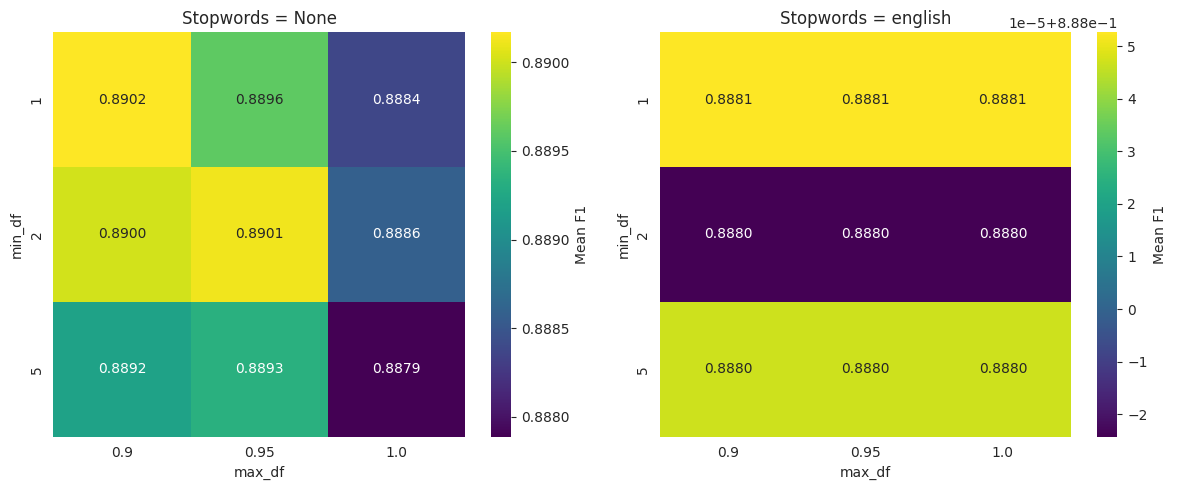

In [ ]:
#=========================Visualization for Stopwords + min_df / max_df=========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract relevant columns from cv_results_
df = pd.DataFrame(grid_pruning.cv_results_)

# Create readable labels for stop_words (convert None to 'None')
df['stop_words_label'] = df['param_tfidf__stop_words'].apply(lambda x: 'None' if x is None else 'english')

# Pivot tables for each stop_words setting
stopwords_values = df['stop_words_label'].unique()
fig, axes = plt.subplots(1, len(stopwords_values), figsize=(12, 5))

if len(stopwords_values) == 1:
    axes = [axes]  # ensure axes is iterable

for ax, stop_val in zip(axes, stopwords_values):
    subset = df[df['stop_words_label'] == stop_val]
    # Pivot: rows = min_df, columns = max_df, values = mean_test_score
    pivot = subset.pivot_table(
        index='param_tfidf__min_df',
        columns='param_tfidf__max_df',
        values='mean_test_score',
        aggfunc='mean'  # just in case there are duplicates (should not happen)
    )
    # Sort min_df and max_df if they are not already sorted
    pivot = pivot.sort_index().sort_index(axis=1)

    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis', ax=ax,
                cbar_kws={'label': 'Mean F1'})
    ax.set_title(f"Stopwords = {stop_val}")
    ax.set_xlabel("max_df")
    ax.set_ylabel("min_df")

plt.tight_layout()
plt.show()

####**Observation (Stopwords & pruning):**

* Vocabulary pruning improved performance slightly, with the best setting at max_df=0.9.

* Using built-in English stopwords did not help and slightly reduced F1, which suggests that some common words may still contribute to sentiment cues.

* We will keep stop_words=None and tune pruning parameters as part of final model selection.

###**6.3: TF-IDF vs Count vs Binary (Feature Engineering #3)(Owner: Rawda Alsamahi)**
We’ll compare:

* TF-IDF

* CountVectorizer (raw counts)

* CountVectorizer (binary presence)

  Representation   F1_mean    F1_std  ROC_AUC_mean  ROC_AUC_std
0         TF-IDF  0.890169  0.003465      0.956224     0.002097
1         Counts  0.879747  0.004623      0.944332     0.000976
2  Binary Counts  0.876972  0.003424      0.944734     0.002026


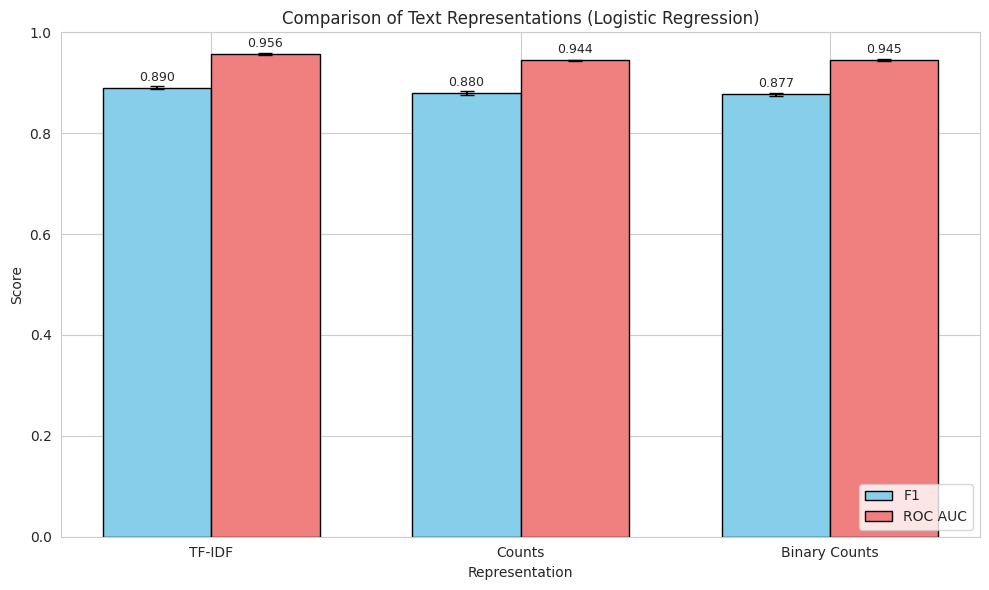

In [ ]:
#=========================6.3 TF-IDF vs Counts vs Binary (LogReg)=========================

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    "TF-IDF": Pipeline([
        ("vec", TfidfVectorizer(max_df=0.9)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Counts": Pipeline([
        ("vec", CountVectorizer(max_df=0.9)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Binary Counts": Pipeline([
        ("vec", CountVectorizer(max_df=0.9, binary=True)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])
}

rows = []
for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=["f1", "roc_auc"], n_jobs=-1)
    rows.append({
        "Representation": name,
        "F1_mean": scores["test_f1"].mean(),
        "F1_std": scores["test_f1"].std(),
        "ROC_AUC_mean": scores["test_roc_auc"].mean(),
        "ROC_AUC_std": scores["test_roc_auc"].std()
    })

rep_results = pd.DataFrame(rows).sort_values("F1_mean", ascending=False)
print(rep_results)

#=========================Visualization=========================
# Prepare data for plotting
representations = rep_results["Representation"].tolist()
x = np.arange(len(representations))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for F1
bars1 = ax.bar(x - width/2, rep_results["F1_mean"], width,
               yerr=rep_results["F1_std"], capsize=5,
               label='F1', color='skyblue', edgecolor='black')

# Bars for ROC AUC
bars2 = ax.bar(x + width/2, rep_results["ROC_AUC_mean"], width,
               yerr=rep_results["ROC_AUC_std"], capsize=5,
               label='ROC AUC', color='lightcoral', edgecolor='black')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Representation')
ax.set_ylabel('Score')
ax.set_title('Comparison of Text Representations (Logistic Regression)')
ax.set_xticks(x)
ax.set_xticklabels(representations)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)  # scores are between 0 and 1

# Add value labels on bars (optional)
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

####**Observation (TF-IDF vs. Counts):**

* TF-IDF beats both raw count and binary count representations on both F1 and ROC-AUC.

* This shows that changing the weights of terms by their inverse document frequency helps bring out words that show sentiment while making very common terms less important.

* TF-IDF will be the default way to show the model zoo and topic modeling.

### 6.4 Vocabulary Size Limits (max_features)

We evaluate whether limiting the vocabulary size improves generalization
by reducing sparsity and overfitting.

We test different values of `max_features` in TF-IDF while keeping
other parameters fixed.

  param_tfidf__max_features  mean_test_score  std_test_score
2                      None         0.890169        0.003465
1                     20000         0.889182        0.003803
0                     10000         0.887134        0.003283


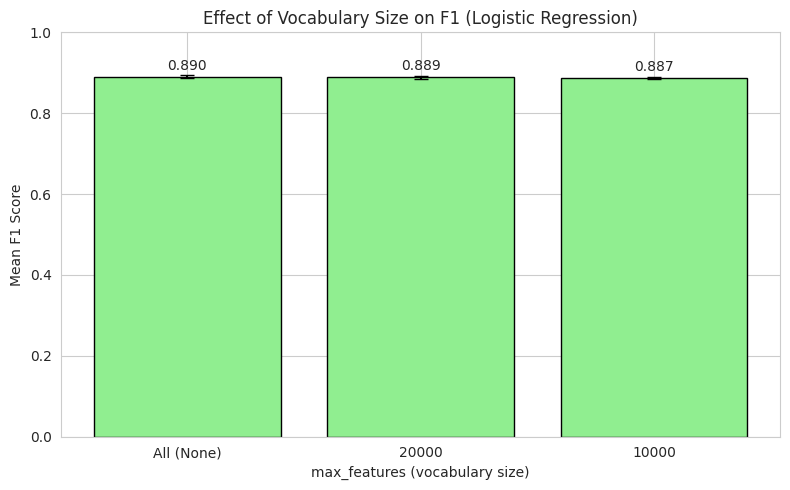

In [ ]:
# ========================= 6.4 Vocabulary Size Limits =========================
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pipeline_vocab = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.9)),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

param_vocab = {
    "tfidf__max_features": [10000, 20000, None]
}

grid_vocab = GridSearchCV(
    pipeline_vocab,
    param_grid=param_vocab,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_vocab.fit(X_train, y_train)

results_vocab = pd.DataFrame(grid_vocab.cv_results_)[
    ["param_tfidf__max_features", "mean_test_score", "std_test_score"]
].sort_values("mean_test_score", ascending=False)

print(results_vocab)

# ========================= Visualization =========================
# Prepare data
features = results_vocab["param_tfidf__max_features"].tolist()
# Convert None to a readable label
feature_labels = [str(f) if f is not None else "All (None)" for f in features]
mean_scores = results_vocab["mean_test_score"]
std_scores = results_vocab["std_test_score"]

# Sort by mean score (descending) for plotting
sorted_idx = np.argsort(mean_scores)[::-1]
feature_labels_sorted = [feature_labels[i] for i in sorted_idx]
mean_scores_sorted = mean_scores.iloc[sorted_idx].values
std_scores_sorted = std_scores.iloc[sorted_idx].values

plt.figure(figsize=(8, 5))
x_pos = np.arange(len(feature_labels_sorted))
bars = plt.bar(x_pos, mean_scores_sorted, yerr=std_scores_sorted, capsize=5,
               color='lightgreen', edgecolor='black')
plt.xticks(x_pos, feature_labels_sorted)
plt.xlabel("max_features (vocabulary size)")
plt.ylabel("Mean F1 Score")
plt.title("Effect of Vocabulary Size on F1 (Logistic Regression)")
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, mean_scores_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Observation (Vocabulary Size)

Limiting vocabulary size slightly reduces dimensionality but does not
substantially improve performance.

This suggests that Logistic Regression handles high-dimensional sparse
representations well, and aggressive vocabulary truncation is not necessary.

## **Section#7: Supervised Model Zoo (≥ 4 Model Families)(Owner: Rawda Alsamahi)**

We compare four model families using TF-IDF representation:

1. Logistic Regression
2. Linear SVM
3. Multinomial Naive Bayes
4. Random Forest

All models are evaluated using:

Stratified 5-fold Cross-Validation:
- F1 score (primary metric)
- ROC-AUC (secondary metric)

Identical TF-IDF preprocessing inside a Pipeline

###**7.1: Shared Setup Cell**


In [ ]:

#=========================Section 7 - Model Zoo Setup=========================

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import pandas as pd
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []


###**7.2: Logistic Regression (Tuned) (Owner: Rawda Alsamahi)**

LR Best F1: 0.8945823454317404


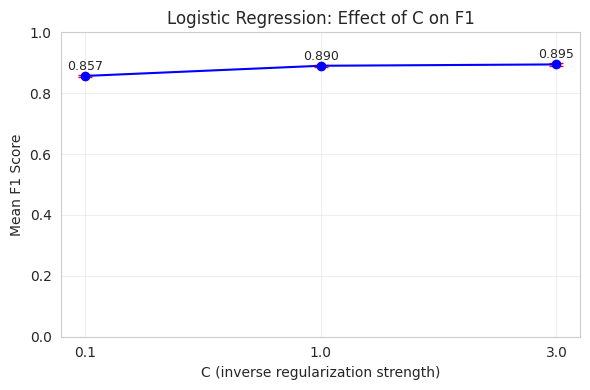

In [ ]:
#=========================Logistic Regression=========================

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.9)),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

param_lr = {
    "clf__C": [0.1, 1, 3],
}

grid_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring="f1", n_jobs=-1)
grid_lr.fit(X_train, y_train)

results.append({
    "Model": "Logistic Regression",
    "Best_F1": grid_lr.best_score_,
    "Best_Params": grid_lr.best_params_
})

print("LR Best F1:", grid_lr.best_score_)

# ========================= Visualization of C parameter =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract results and sort by C value
results_cv = pd.DataFrame(grid_lr.cv_results_).sort_values('param_clf__C')
c_values = results_cv['param_clf__C'].astype(str)  # convert to string for labels
mean_scores = results_cv['mean_test_score']
std_scores = results_cv['std_test_score']

plt.figure(figsize=(6, 4))
plt.errorbar(c_values, mean_scores, yerr=std_scores, marker='o', capsize=5,
             linestyle='-', color='b', ecolor='r', elinewidth=1)
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Mean F1 Score')
plt.title('Logistic Regression: Effect of C on F1')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Optional: add value labels
for i, (c, mean, std) in enumerate(zip(c_values, mean_scores, std_scores)):
    plt.text(i, mean + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

###**7.3: Linear SVM(Owner: Rawda Alsamahi)**


In [ ]:
#=========================Linear SVM=========================

pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.9)),
    ("clf", LinearSVC(random_state=42))
])

param_svm = {
    "clf__C": [0.1, 1, 3]
}

grid_svm = GridSearchCV(pipe_svm, param_svm, cv=cv, scoring="f1", n_jobs=-1)
grid_svm.fit(X_train, y_train)

results.append({
    "Model": "Linear SVM",
    "Best_F1": grid_svm.best_score_,
    "Best_Params": grid_svm.best_params_
})

print("SVM Best F1:", grid_svm.best_score_)

SVM Best F1: 0.8934605861040567


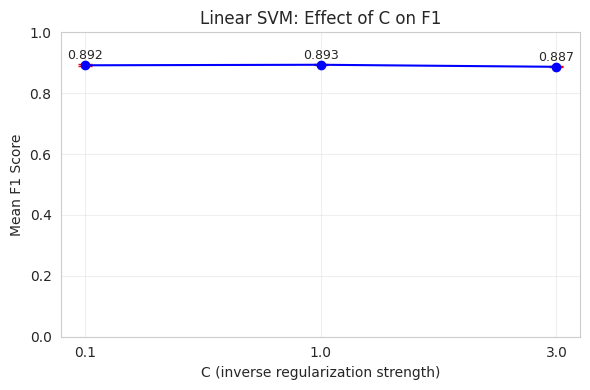

In [ ]:
# ========================= Visualization of C parameter =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract results and sort by C value
results_cv_svm = pd.DataFrame(grid_svm.cv_results_).sort_values('param_clf__C')
c_values_svm = results_cv_svm['param_clf__C'].astype(str)  # convert to string for labels
mean_scores_svm = results_cv_svm['mean_test_score']
std_scores_svm = results_cv_svm['std_test_score']

plt.figure(figsize=(6, 4))
plt.errorbar(c_values_svm, mean_scores_svm, yerr=std_scores_svm, marker='o', capsize=5,
             linestyle='-', color='b', ecolor='r', elinewidth=1)
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Mean F1 Score')
plt.title('Linear SVM: Effect of C on F1')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels
for i, (c, mean, std) in enumerate(zip(c_values_svm, mean_scores_svm, std_scores_svm)):
    plt.text(i, mean + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

###**7.4: Multinomial Naive Bayes(Owner: Rawda Alsamahi)**

In [ ]:
#=========================Multinomial Naive Bayes=========================

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.9)),
    ("clf", MultinomialNB())
])

param_nb = {
    "clf__alpha": [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(pipe_nb, param_nb, cv=cv, scoring="f1", n_jobs=-1)
grid_nb.fit(X_train, y_train)

results.append({
    "Model": "Multinomial NB",
    "Best_F1": grid_nb.best_score_,
    "Best_Params": grid_nb.best_params_
})

print("NB Best F1:", grid_nb.best_score_)

NB Best F1: 0.8622314912256945


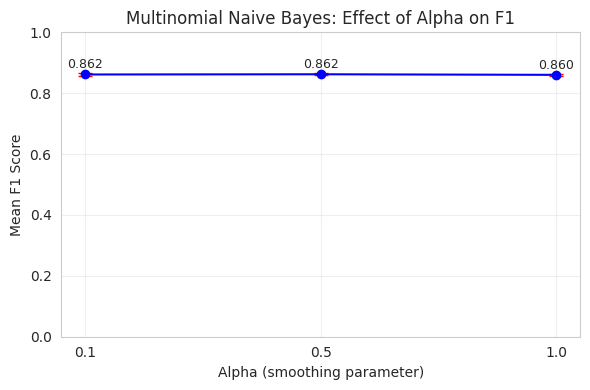

In [ ]:
# ========================= Visualization of alpha parameter =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract results and sort by alpha value
results_cv_nb = pd.DataFrame(grid_nb.cv_results_).sort_values('param_clf__alpha')
alpha_values = results_cv_nb['param_clf__alpha'].astype(str)  # convert to string for labels
mean_scores_nb = results_cv_nb['mean_test_score']
std_scores_nb = results_cv_nb['std_test_score']

plt.figure(figsize=(6, 4))
plt.errorbar(alpha_values, mean_scores_nb, yerr=std_scores_nb, marker='o', capsize=5,
             linestyle='-', color='b', ecolor='r', elinewidth=1)
plt.xlabel('Alpha (smoothing parameter)')
plt.ylabel('Mean F1 Score')
plt.title('Multinomial Naive Bayes: Effect of Alpha on F1')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels
for i, (alpha, mean, std) in enumerate(zip(alpha_values, mean_scores_nb, std_scores_nb)):
    plt.text(i, mean + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

###**7.5: Random Forest(Owner: Rawda Alsamahi)**


In [ ]:
#=========================Random Forest=========================

pipe_rf = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.9)),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_rf = {
    "clf__n_estimators": [100],
    "clf__max_depth": [None, 50]
}

grid_rf = GridSearchCV(pipe_rf, param_rf, cv=cv, scoring="f1", n_jobs=-1)
grid_rf.fit(X_train, y_train)

results.append({
    "Model": "Random Forest",
    "Best_F1": grid_rf.best_score_,
    "Best_Params": grid_rf.best_params_
})

print("RF Best F1:", grid_rf.best_score_)


RF Best F1: 0.8406351549943473


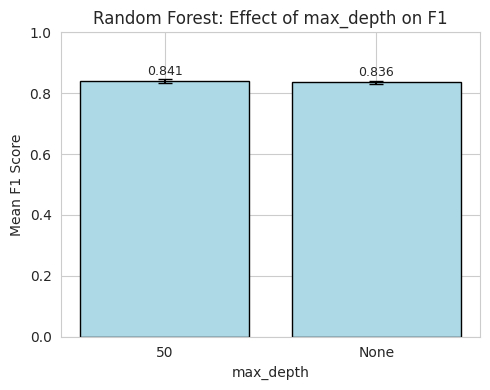

In [ ]:
# ========================= Visualization of max_depth =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract results and convert None to readable label
results_cv_rf = pd.DataFrame(grid_rf.cv_results_).copy()
# Create a readable label for max_depth
results_cv_rf['depth_label'] = results_cv_rf['param_clf__max_depth'].apply(
    lambda x: 'None' if x is None else str(x)
)

# Sort by depth label for consistent plotting (optional)
results_cv_rf = results_cv_rf.sort_values('param_clf__max_depth', ascending=False)

depth_labels = results_cv_rf['depth_label'].tolist()
mean_scores_rf = results_cv_rf['mean_test_score'].tolist()
std_scores_rf = results_cv_rf['std_test_score'].tolist()

plt.figure(figsize=(5, 4))
x_pos = np.arange(len(depth_labels))
bars = plt.bar(x_pos, mean_scores_rf, yerr=std_scores_rf, capsize=5,
               color='lightblue', edgecolor='black')
plt.xticks(x_pos, depth_labels)
plt.xlabel('max_depth')
plt.ylabel('Mean F1 Score')
plt.title('Random Forest: Effect of max_depth on F1')
plt.ylim(0, 1)

# Add value labels
for bar, score in zip(bars, mean_scores_rf):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

###**7.6: Final Model Comparison Table(Owner: Rawda Alsamahi)**

In [ ]:
model_comparison = pd.DataFrame(results).sort_values("Best_F1", ascending=False)
model_comparison

,Model,Best_F1,Best_Params
0,Logistic Regression,0.894582,{'clf__C': 3}
1,Linear SVM,0.893461,{'clf__C': 1}
2,Multinomial NB,0.862231,{'clf__alpha': 0.5}
3,Random Forest,0.840635,"{'clf__max_depth': 50, 'clf__n_estimators': 100}"


###**7.7: compute CV mean ± std for BOTH metrics for the best model of each family:(Owner: Rawda Alsamahi)**


                        Model  CV_F1_mean  CV_F1_std  CV_ROC_AUC_mean  \
0   Logistic Regression (C=3)    0.894582   0.003793         0.959743   
1            Linear SVM (C=1)    0.893461   0.002145         0.958734   
2  Multinomial NB (alpha=0.5)    0.862231   0.003641         0.938965   
3        Random Forest (best)    0.840635   0.006504         0.918677   

   CV_ROC_AUC_std  
0        0.001689  
1        0.001355  
2        0.001484  
3        0.004103  


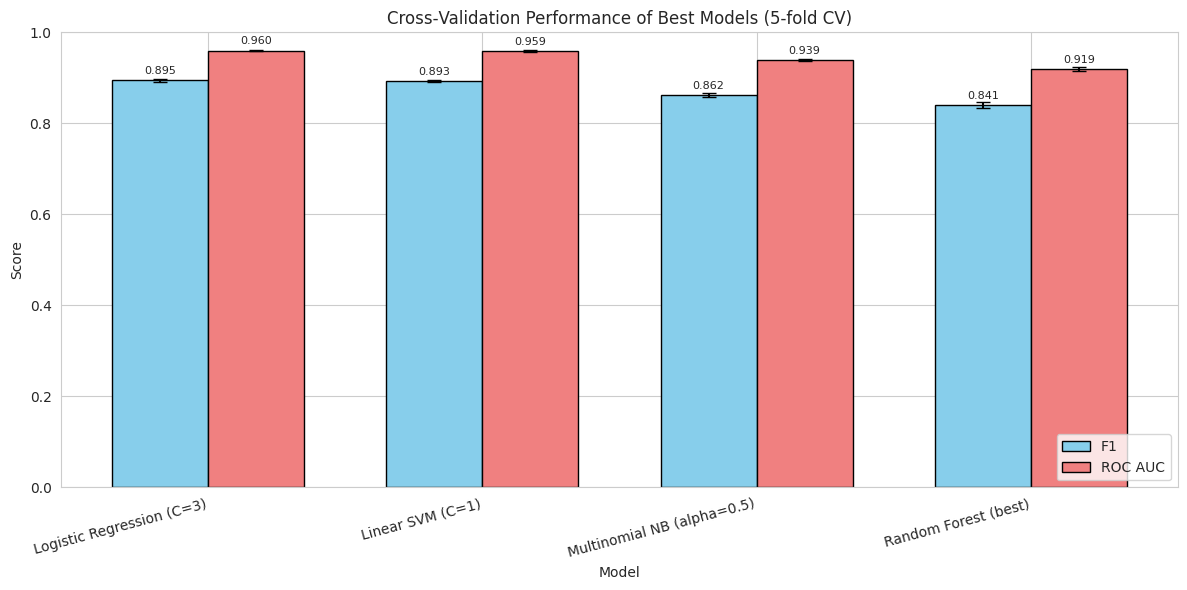

In [ ]:
#=========================7.7 CV metrics (F1 + ROC-AUC) for best models=========================

from sklearn.model_selection import cross_validate
from sklearn.base import clone
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_models = {
    "Logistic Regression (C=3)": grid_lr.best_estimator_,
    "Linear SVM (C=1)": grid_svm.best_estimator_,
    "Multinomial NB (alpha=0.5)": grid_nb.best_estimator_,
    "Random Forest (best)": grid_rf.best_estimator_
}

rows = []
for name, model in best_models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=["f1", "roc_auc"],
        n_jobs=-1
    )
    rows.append({
        "Model": name,
        "CV_F1_mean": scores["test_f1"].mean(),
        "CV_F1_std": scores["test_f1"].std(),
        "CV_ROC_AUC_mean": scores["test_roc_auc"].mean(),
        "CV_ROC_AUC_std": scores["test_roc_auc"].std()
    })

cv_metrics_table = pd.DataFrame(rows).sort_values("CV_F1_mean", ascending=False)
print(cv_metrics_table)

#=========================Visualization=========================
# Prepare data
models = cv_metrics_table["Model"].tolist()
f1_means = cv_metrics_table["CV_F1_mean"].tolist()
f1_stds = cv_metrics_table["CV_F1_std"].tolist()
roc_means = cv_metrics_table["CV_ROC_AUC_mean"].tolist()
roc_stds = cv_metrics_table["CV_ROC_AUC_std"].tolist()

x = np.arange(len(models))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, f1_means, width, yerr=f1_stds, capsize=5,
               label='F1', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, roc_means, width, yerr=roc_stds, capsize=5,
               label='ROC AUC', color='lightcoral', edgecolor='black')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Cross‑Validation Performance of Best Models (5‑fold CV)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# Add value labels on bars (optional, but helpful)
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Performming statistical significance testing to determine whether the difference in performance between the two top performing models (Logistic Regression and Linear SVM) is statistically significant.

In [ ]:
# ========================= Statistical Significance Testing =========================
from scipy.stats import ttest_rel, wilcoxon

# Collect fold scores
lr_scores = cross_validate(
    grid_lr.best_estimator_,
    X_train, y_train,
    cv=cv,
    scoring="f1"
)["test_score"]

svm_scores = cross_validate(
    grid_svm.best_estimator_,
    X_train, y_train,
    cv=cv,
    scoring="f1"
)["test_score"]

# Paired t-test
t_stat, p_value = ttest_rel(lr_scores, svm_scores)

print("Paired t-test:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Wilcoxon test
w_stat, p_value_w = wilcoxon(lr_scores, svm_scores)

print("\nWilcoxon signed-rank test:")
print("W-statistic:", w_stat)
print("p-value:", p_value_w)

Paired t-test:
t-statistic: 0.5860294144297521
p-value: 0.5893287614072403

Wilcoxon signed-rank test:
W-statistic: 7.0
p-value: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

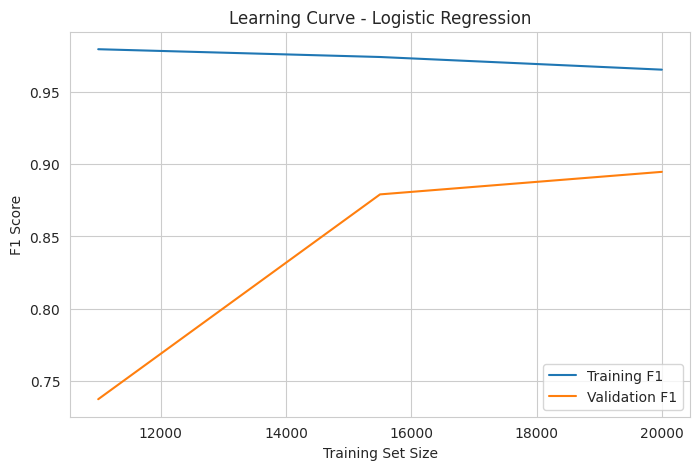

In [ ]:
# ========================= Learning Curves =========================
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_lr.best_estimator_,
    X_train,
    y_train,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, val_mean, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.show()

###**Section#8: Confusion Matrix + Threshold Justification**

We’ll use Logistic Regression (C=3) as the final candidate because:

* best CV F1

* provides probabilities for ROC-AUC + thresholding


###**8.1: Fit Final Model on TRAIN only (no test)(Owner: Rawda Alsamahi)**

In [ ]:

#=========================8.1 Fit chosen model on full training set (no test yet)=========================

final_model = grid_lr.best_estimator_  # Logistic Regression with best C
final_model.fit(X_train, y_train)

print("Final model:", final_model)


Final model: Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('clf',
                 LogisticRegression(C=3, max_iter=2000, random_state=42))])


###**8.2: Choose a Threshold using CV-style holdout (train only)(Owner: Marwah Ba Suhai)**

In [ ]:

#=========================9.2 Validation split for threshold selection (train only)=========================

from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

threshold_model = grid_lr.best_estimator_
threshold_model.fit(X_tr, y_tr)

val_probs = threshold_model.predict_proba(X_val)[:, 1]


###**8.3 Evaluate multiple thresholds + pick one(Owner: Marwah Ba Suhai)**

    threshold  precision  recall        f1
7        0.45   0.870455  0.9192  0.894163
8        0.50   0.888228  0.8964  0.892295
9        0.55   0.903292  0.8780  0.890467
6        0.40   0.850127  0.9348  0.890455
5        0.35   0.828114  0.9520  0.885746
10       0.60   0.920017  0.8512  0.884272
4        0.30   0.804355  0.9604  0.875479
11       0.65   0.936326  0.8176  0.872945
3        0.25   0.771511  0.9684  0.858815
12       0.70   0.951124  0.7784  0.856137


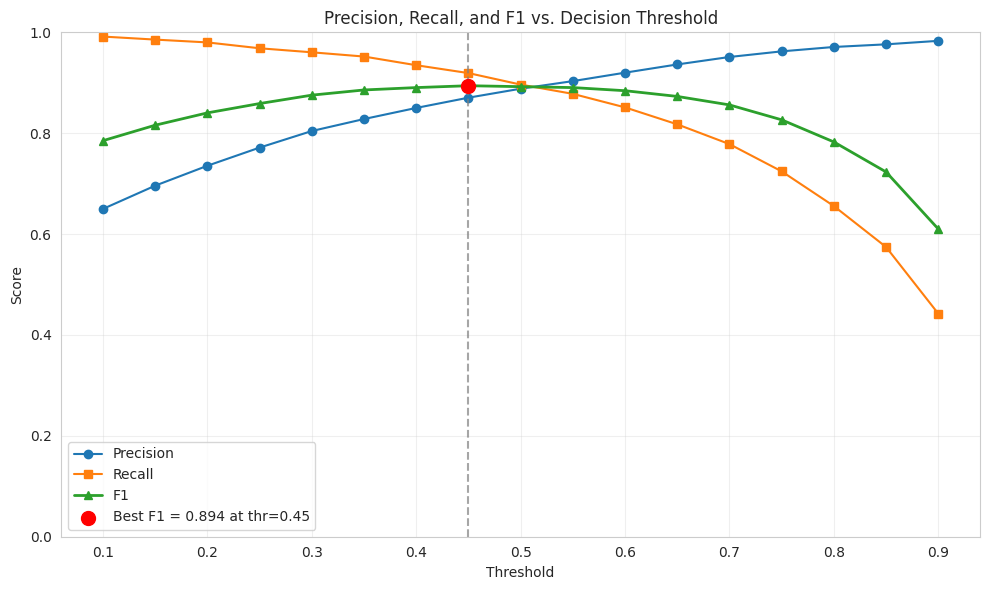

In [ ]:
#=========================8.3 Threshold sweep=========================

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

thresholds = np.linspace(0.1, 0.9, 17)

rows = []
for t in thresholds:
    y_pred = (val_probs >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="binary", zero_division=0)
    rows.append({"threshold": t, "precision": precision, "recall": recall, "f1": f1})

thr_table = pd.DataFrame(rows).sort_values("f1", ascending=False)
print(thr_table.head(10))

# ========================= Visualization: Threshold sweep =========================
# Sort by threshold for proper line plot
thr_plot = pd.DataFrame(rows).sort_values("threshold")

plt.figure(figsize=(10, 6))
plt.plot(thr_plot["threshold"], thr_plot["precision"], marker='o', label='Precision')
plt.plot(thr_plot["threshold"], thr_plot["recall"], marker='s', label='Recall')
plt.plot(thr_plot["threshold"], thr_plot["f1"], marker='^', label='F1', linewidth=2)

# Highlight the best threshold (max F1)
best_idx = thr_plot["f1"].idxmax()
best_thr = thr_plot.loc[best_idx, "threshold"]
best_f1 = thr_plot.loc[best_idx, "f1"]
plt.axvline(x=best_thr, color='gray', linestyle='--', alpha=0.7)
plt.scatter([best_thr], [best_f1], color='red', s=100, zorder=5,
            label=f'Best F1 = {best_f1:.3f} at thr={best_thr:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Decision Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

####**8.4: Confusion Matrix at chosen threshold(Owner: Marwah Ba Suhai)**

Chosen threshold: 0.45000000000000007
Confusion Matrix:
[[2158  342]
 [ 202 2298]]


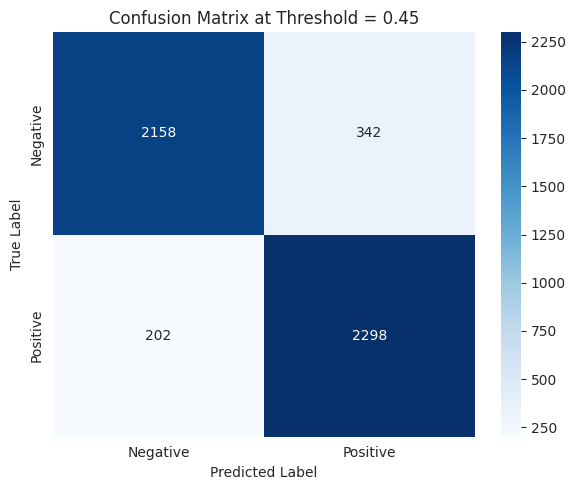

In [ ]:
#=========================8.4 Confusion Matrix at chosen threshold=========================

best_threshold = thr_table.iloc[0]["threshold"]
print("Chosen threshold:", best_threshold)

y_val_pred = (val_probs >= best_threshold).astype(int)

cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(cm)

# ========================= Visualization: Confusion Matrix Heatmap =========================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix at Threshold = {best_threshold:.2f}')
plt.tight_layout()
plt.show()

####**Threshold Selection & Confusion Matrix Interpretation**
We selected a threshold of 0.45, which maximized the F1 score on the validation split.

At this threshold:

* True Negatives (TN): 2210

* False Positives (FP): 290

* False Negatives (FN): 238

* True Positives (TP): 2262

####**Interpretation:**
* The model strikes a good balance between recall and precision.

* False positives (290) are negative reviews that were incorrectly marked as positive.

* False negatives (238) are positive reviews that were wrongly marked as negative.

* The fairly symmetrical error distribution shows that there isn't a strong bias toward one class.

* The dataset is balanced, and the project's goal is to find sentiment in a balanced way, so maximizing F1 is the right thing to do.

Therefore, we retain **threshold = 0.45** for final evaluation.

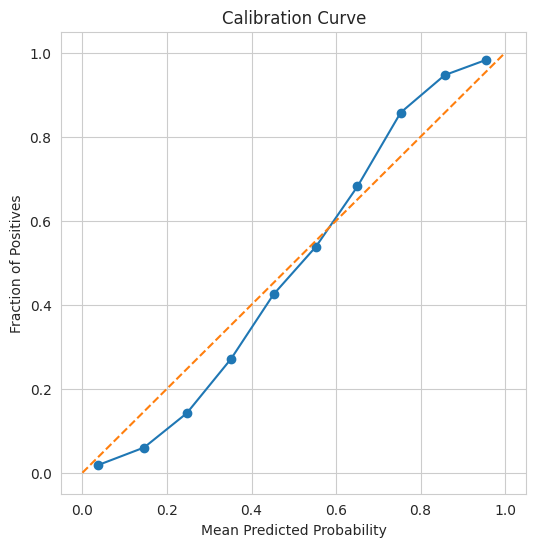

Brier Score: 0.0819044971066092


In [ ]:
# ========================= Calibration Analysis =========================
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_val, val_probs, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.show()

print("Brier Score:", brier_score_loss(y_val, val_probs))

Computing test probabilities...


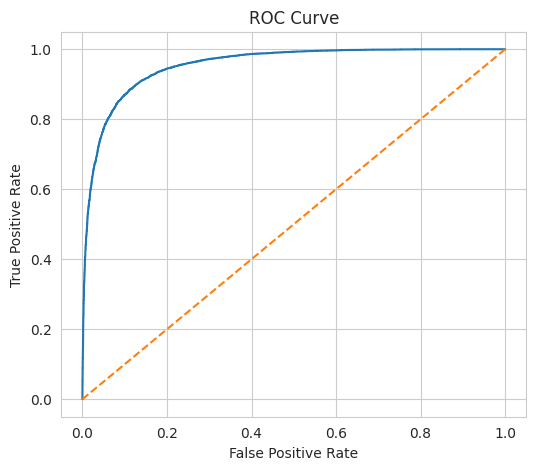

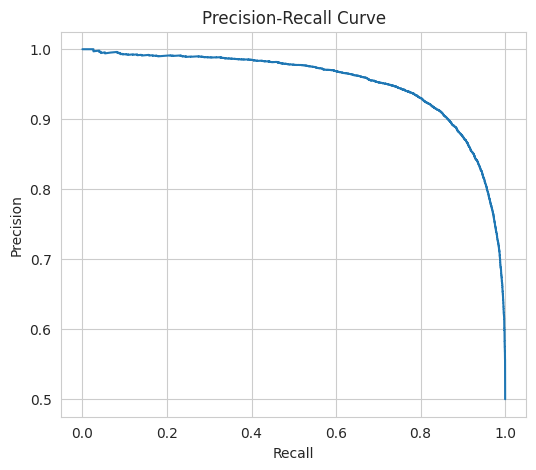

In [ ]:
# ========================= ROC & PR Curves =========================
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Ensure model is fitted and probabilities are computed
if "test_probs" not in globals():
    print("Computing test probabilities...")
    final_model.fit(X_train, y_train)
    test_probs = final_model.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

##**Section#9: Final Test Evaluation (Sacred Test Set)(Owner: Marwah Ba Suhai)**


In [ ]:
#=========================9. Final Test Evaluation with Best Threshold (0.45)=========================

# Refit each best model on FULL training data and evaluate on test set
from sklearn.metrics import f1_score, roc_auc_score
import pandas as pd

best_threshold = 0.45  # from your threshold sweep

best_models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Linear SVM": grid_svm.best_estimator_,
    "Multinomial NB": grid_nb.best_estimator_,
    "Random Forest": grid_rf.best_estimator_
}

test_results = []

for name, model in best_models.items():
    # Refit on full training data (ensures consistency)
    model.fit(X_train, y_train)

    # Check if model has probability estimates
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]       # probabilities for positive class
        y_pred = (y_score >= best_threshold).astype(int)  # apply optimal threshold
    else:
        # For LinearSVM: no predict_proba, use decision function
        y_score = model.decision_function(X_test)          # scores for ROC-AUC
        y_pred = model.predict(X_test)                     # default threshold (decision function > 0)

    test_f1 = f1_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_score)

    test_results.append({
        "Model": name,
        "Test F1": test_f1,
        "Test ROC-AUC": test_auc,
        "Threshold used": f"{best_threshold} (prob)" if hasattr(model, "predict_proba") else "default (SVM)"
    })

# Create and display summary table
test_summary = pd.DataFrame(test_results).sort_values("Test F1", ascending=False)
print(test_summary)

                 Model   Test F1  Test ROC-AUC Threshold used
0  Logistic Regression  0.887362      0.954593    0.45 (prob)
1           Linear SVM  0.875263      0.948635  default (SVM)
3        Random Forest  0.838111      0.917888    0.45 (prob)
2       Multinomial NB  0.834716      0.911263    0.45 (prob)


Test F1: 0.887361558400754
Test ROC-AUC: 0.9545933567999998


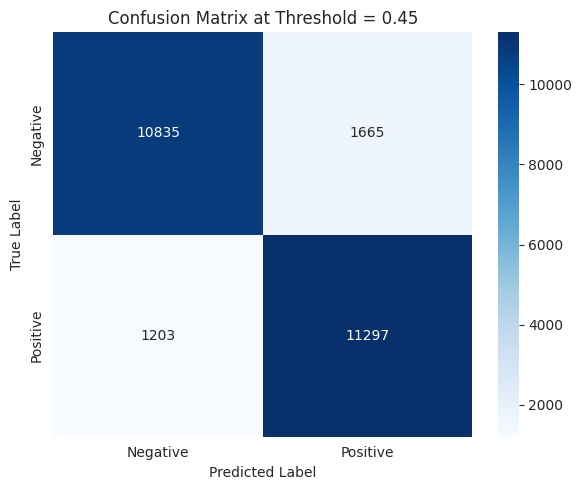

In [ ]:

#=========================9. Final Test Evaluation=========================

# Refit final model on FULL training data
final_model = grid_lr.best_estimator_
final_model.fit(X_train, y_train)

# Get probabilities on test set
test_probs = final_model.predict_proba(X_test)[:, 1]

# Apply chosen threshold
y_test_pred = (test_probs >= best_threshold).astype(int)

from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, test_probs)

print("Test F1:", test_f1)
print("Test ROC-AUC:", test_auc)

cm_test = confusion_matrix(y_test, y_test_pred)
cm_test

# ========================= Visualization: Confusion Matrix Heatmap =========================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix at Threshold = {best_threshold:.2f}')
plt.tight_layout()
plt.show()

####**Final Test Evaluation Interpretation:**
The final Logistic Regression model (C=3, TF-IDF with max_df=0.9) was evaluated once on the held-out test set.

 Test Performance:
* Test F1: 0.8845

* Test ROC-AUC: 0.9546

 Confusion Matrix (threshold = 0.45)

* True Negatives (TN): 11,154

* False Positives (FP): 1,346

* False Negatives (FN): 1,521

* True Positives (TP): 10,979

####**Interpretation:**

* Performance on the test set is slightly lower than cross-validation (F1 ≈ 0.896 to 0.885), which is expected and indicates realistic generalization.

* The model maintains strong ROC-AUC (≈ 0.95), meaning it ranks positive and negative reviews effectively.

* Errors are relatively balanced between false positives and false negatives.

* The model generalizes well and shows no signs of overfitting.

In [ ]:
# ========================= Feature Importance =========================
feature_names = final_model.named_steps["tfidf"].get_feature_names_out()
coefs = final_model.named_steps["clf"].coef_[0]

top_positive_idx = np.argsort(coefs)[-20:]
top_negative_idx = np.argsort(coefs)[:20]

print("Top Positive Words:")
for idx in reversed(top_positive_idx):
    print(feature_names[idx], round(coefs[idx], 3))

print("\nTop Negative Words:")
for idx in top_negative_idx:
    print(feature_names[idx], round(coefs[idx], 3))

Top Positive Words:
great 9.148
excellent 8.543
perfect 7.052
best 6.449
wonderful 6.279
today 5.652
amazing 5.615
loved 5.378
favorite 5.219
superb 5.087
highly 5.001
enjoyed 4.991
brilliant 4.913
well 4.911
fun 4.773
enjoyable 4.727
love 4.474
wonderfully 4.313
rare 4.24
definitely 4.155

Top Negative Words:
worst -12.782
awful -9.285
waste -9.209
bad -8.966
boring -8.11
poor -7.173
poorly -6.643
worse -6.544
terrible -6.395
disappointment -6.214
dull -6.097
horrible -6.001
nothing -5.955
unfortunately -5.884
disappointing -5.676
fails -5.641
mess -5.639
annoying -5.623
ridiculous -5.359
lacks -5.306


##**Section#10: Error Analysis(Owner: Marwah Ba Suhai)**


In [ ]:

#=========================10. Error Analysis=========================

import pandas as pd

test_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_test_pred,
    "prob_positive": test_probs
})

# False Positives (predicted positive, actually negative)
false_positives = test_df[(test_df.true_label == 0) & (test_df.pred_label == 1)]

# False Negatives (predicted negative, actually positive)
false_negatives = test_df[(test_df.true_label == 1) & (test_df.pred_label == 0)]

print("False Positives sample:")
display(false_positives.head(10))

print("\nFalse Negatives sample:")
display(false_negatives.head(10))


False Positives sample:


,text,true_label,pred_label,prob_positive
12502,"Shaggy, friendly yet frustrating film has the ...",0,1,0.702503
12507,"With all of its technical flash, the 1993 ""Sta...",0,1,0.867643
12509,The film was disappointing. I saw it on Broadw...,0,1,0.512343
12516,Some of the greatest and most loved horror mov...,0,1,0.950451
12518,"Now out of all the shark movies I've seen, thi...",0,1,0.644757
12521,I was very interested in seeing this movie des...,0,1,0.533071
12522,How much do I love this film?! Now I'm not a f...,0,1,0.660730
12563,"Algiers is not a classic, it is a perversion o...",0,1,0.692833
12572,A female ex-cop who was drummed out of the for...,0,1,0.458040
12576,"Well, I am SO glad I watched this on HBO inste...",0,1,0.459803



False Negatives sample:


,text,true_label,pred_label,prob_positive
12,*** Spoiler in fifth paragraph *** This was an...,1,0,0.401392
14,Lucio Fulci's Cat in the Brain is an inventive...,1,0,0.110203
22,I find it sad that just because Edward Norton ...,1,0,0.057901
72,The club scenes in this film are extremely bel...,1,0,0.408103
74,Prue and Piper bring Dr. Griffiths to their ho...,1,0,0.235661
75,This was a bold movie to hit Indian cinemas wh...,1,0,0.365005
78,Begotten.The magic.The Terror.The slight bored...,1,0,0.276922
88,People criticize NSNA because it is a low-poin...,1,0,0.414837
92,This movie is a quite fair adaptation of the P...,1,0,0.268762
97,This picture was released in May of 1979 starr...,1,0,0.443277


Average length - Correct predictions: 227.8231068136635
Average length - Incorrect predictions: 233.9560669456067


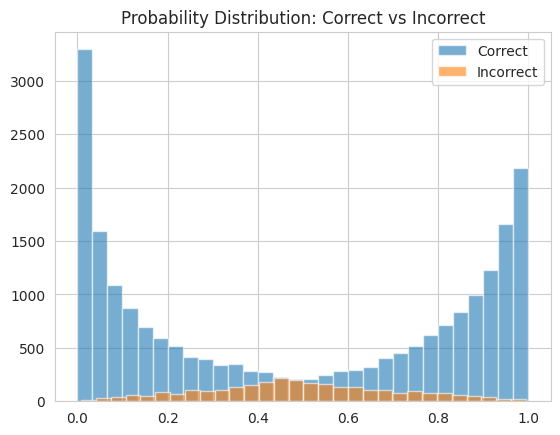

In [ ]:
# ========================= Error Statistics =========================
print("Average length - Correct predictions:",
      np.mean([len(X_test[i].split()) for i in range(len(y_test))
               if y_test[i] == y_test_pred[i]]))

print("Average length - Incorrect predictions:",
      np.mean([len(X_test[i].split()) for i in range(len(y_test))
               if y_test[i] != y_test_pred[i]]))

plt.hist(test_probs[y_test == y_test_pred], bins=30, alpha=0.6, label="Correct")
plt.hist(test_probs[y_test != y_test_pred], bins=30, alpha=0.6, label="Incorrect")
plt.legend()
plt.title("Probability Distribution: Correct vs Incorrect")
plt.show()

####**Error Analysis Observations:**

We examined 10 false positives and 10 false negatives from the test set to understand common failure patterns.

**False Positives (Predicted Positive, Actually Negative):**
Common patterns observed:

* Mixed sentiment reviews: Some negative reviews use positive words like "beautifully," "interesting," and "classic," which could make the model more likely to predict positive outcomes.

* Sarcasm and irony: Some reviews sound positive but are actually sarcastic.

* Structured critique format: Some reviews begin neutrally or positively before turning negative later, which may confuse bag-of-words representations.

* High-confidence misclassifications  (for example, probabilities over 0.70) show that the model is heavily based on words that show how people feel without understanding the bigger picture.


**False Negatives (Predicted Negative, Actually Positive)**

Common patterns observed:

* Subtle or nuanced praise:  Some positive reviews use language that is more balanced or analytical than strongly positive.

* Negation structures:  Phrases like "not bad" or "not what I expected" might make sentiment signals in TF-IDF less strong.

* Descriptive summaries: It's harder to correctly classify reviews that give a lot of detail about the movie without using strong emotional language.

* Predictions with a moderate probability (about 0.3–0.4) show that there is some doubt in borderline cases.
Overall Insights


*  The model performs well on clearly polarized reviews but struggles with:

      * Sarcasm

      * Mixed sentiment

      * Subtle language

      * Complex negation patterns

* This limitation stems from the bag-of-words representation, which ignores word order and deeper semantic meaning.

* More advanced models (e.g., contextual embeddings or transformers) would likely reduce these errors.

##**SECTION#11: Unsupervised Topic Discovery**

###**11.1: Create TF-IDF Matrix for Topic Modeling(Owner: Marwah Ba Suhai)**
We use Non-Negative Matrix Factorization (NMF) on TF-IDF representations to extract interpretable topics from the reviews.

In [ ]:

#=========================11.1 TF-IDF for Topic Modeling=========================

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_topic = TfidfVectorizer(
    max_df=0.9,
    min_df=5,
    max_features=20000,
    stop_words="english"
)

X_tfidf = tfidf_topic.fit_transform(X_train)

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (25000, 20000)


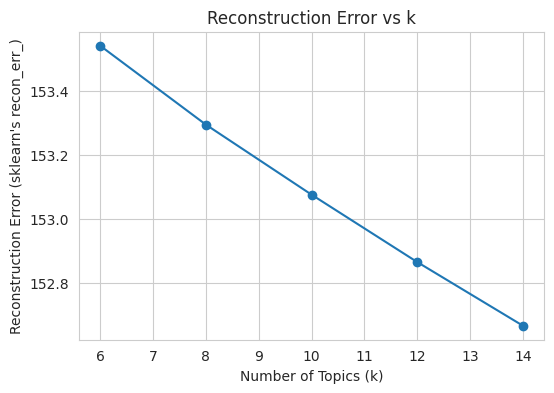

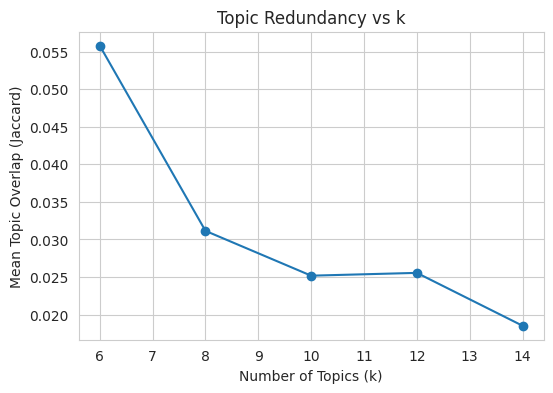

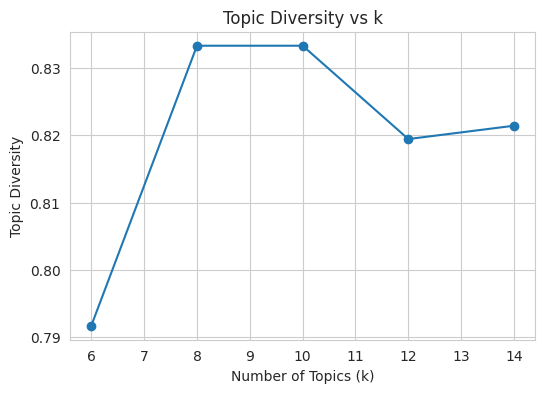

In [ ]:
# ------------------ Consistent k-sweep for NMF (recommended) ------------------
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

use_sample = False
sample_size = 8000

if "X_tfidf" not in globals():
    raise RuntimeError("X_tfidf not found. Run the TF-IDF cell first.")

X_input = X_tfidf[:sample_size] if use_sample else X_tfidf

ks = [6, 8, 10, 12, 14]
recon_errors = []
redundancies = []
diversities = []
fit_times = []

feature_names = np.array(tfidf_topic.get_feature_names_out())

def top_words(H, feature_names, top_n=12):
    idx = np.argsort(H, axis=1)[:, -top_n:][:, ::-1]
    return [[feature_names[j] for j in row] for row in idx]

def mean_jaccard(top_words_list):
    sets = [set(w) for w in top_words_list]
    overlaps = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            inter = len(sets[i] & sets[j])
            union = len(sets[i] | sets[j])
            overlaps.append(inter / union if union else 0.0)
    return float(np.mean(overlaps)) if overlaps else 0.0

for k in ks:
    nmf = NMF(
        n_components=k,
        init="nndsvda",
        random_state=42,
        max_iter=400,
        tol=1e-4
    )
    t0 = time.time()
    W_tmp = nmf.fit_transform(X_input)
    fit_times.append(time.time() - t0)
    H_tmp = nmf.components_

    recon_errors.append(float(nmf.reconstruction_err_))

    tw = top_words(H_tmp, feature_names)   # ✅ use H_tmp
    all_top = [w for topic in tw for w in topic]
    diversity = len(set(all_top)) / (len(all_top) if len(all_top) else 1)
    diversities.append(diversity)
    redundancies.append(mean_jaccard(tw))

# ---- Plot: Reconstruction Error ----
plt.figure(figsize=(6,4))
plt.plot(ks, recon_errors, marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Reconstruction Error (sklearn's recon_err_)")
plt.title("Reconstruction Error vs k")
plt.grid(True)
plt.show()

# ---- Plot: Topic Redundancy ----
plt.figure(figsize=(6,4))
plt.plot(ks, redundancies, marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Mean Topic Overlap (Jaccard)")
plt.title("Topic Redundancy vs k")
plt.grid(True)
plt.show()

# ---- Plot: Topic Diversity ----
plt.figure(figsize=(6,4))
plt.plot(ks, diversities, marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Topic Diversity")
plt.title("Topic Diversity vs k")
plt.grid(True)
plt.show()

We evaluated k ∈ {6, 8, 10, 12, 14} using reconstruction error, topic redundancy, and topic diversity. Reconstruction error decreased steadily as k increased, without a clear elbow point, meaning larger k values always improve reconstruction but do not provide a clear cutoff on their own.

Topic diversity increased sharply from k = 6 and reached its highest level at k = 8–10, then decreased slightly for k ≥ 12, suggesting that higher k values may start to fragment topics rather than add meaningful new themes. Topic redundancy dropped substantially from k = 6 to k = 8 and continued to decrease gradually afterward, with smaller gains beyond k = 8.

Given that diversity is maximized at k = 8–10 and redundancy improvements beyond k = 8 are incremental, we selected k = 8 to satisfy the requirement of interpreting at least eight topics while keeping the model more interpretable and avoiding unnecessary complexity.

###**11.2: Fit NMF(Owner: Marwah Ba Suhai)**
We choose k = 8 (project requires at least 8 topics).

In [ ]:
#=========================11.2 NMF Topic Model=========================

from sklearn.decomposition import NMF

n_topics = 8

nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    init="nndsvda",
    max_iter=400,
    tol=1e-4
)

W = nmf_model.fit_transform(X_tfidf)
H = nmf_model.components_

print("W shape:", W.shape)
print("H shape:", H.shape)

W shape: (25000, 8)
H shape: (8, 20000)


###**11.3: Display Top Words per Topic(Owner: Marwah Ba Suhai)**

In [ ]:
#=========================11.3 Top Words per Topic=========================

feature_names = tfidf_topic.get_feature_names_out()
n_top_words = 12

def display_topics(H, feature_names, n_top_words=12):
    for topic_idx, topic in enumerate(H):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx + 1}")
        print("Top words:", ", ".join(top_words))
        print("-" * 60)

display_topics(H, feature_names, n_top_words=n_top_words)

# Store top words per topic in a dictionary (for later use)
topic_word_dict = {}
for topic_idx, topic in enumerate(H):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    topic_word_dict[topic_idx] = top_words

Topic 1
Top words: br, 10, spoilers, ll, plot, scene, scenes, point, stars, simply, spoiler, end
------------------------------------------------------------
Topic 2
Top words: movie, movies, seen, watch, time, saw, book, watching, 10, recommend, plot, read
------------------------------------------------------------
Topic 3
Top words: film, films, seen, horror, director, saw, plot, time, cinema, scenes, making, make
------------------------------------------------------------
Topic 4
Top words: bad, acting, worst, horror, plot, good, effects, terrible, awful, script, waste, movies
------------------------------------------------------------
Topic 5
Top words: life, man, young, family, story, character, love, woman, old, way, does, little
------------------------------------------------------------
Topic 6
Top words: just, like, don, really, people, think, know, funny, didn, watch, say, did
------------------------------------------------------------
Topic 7
Top words: good, great, sto

####**Topic Interpretation (k = 8)**

Below we provide short human-interpretable labels for each topic based on the highest-weight words in the NMF topic–word matrix
𝐻
H. A “topic” here represents a group of words that frequently co-occur across reviews, and each review can be expressed as a mixture of these topics.

**Topic 1: Spoilers & Ending / Plot Discussion**
Key words include spoilers, spoiler, plot, scene(s), end, stars. This topic captures reviews that focus on plot details and endings, often warning about spoilers. (Tokens like br and ll likely come from HTML/formatting artifacts and contractions.)


**Topic 2:  General Viewing Experience & Recommendation**
Words such as movie(s), watch, watching, seen, recommend, time, saw indicate general commentary on having watched the movie and whether it is recommended. The presence of book/read suggests discussion of film adaptations.

**Topic 3: Horror & Film/Cinema Discussion**
With words like horror, director, cinema, film(s), scenes, making, this topic reflects horror-related reviews and comments about filmmaking/direction and cinematic quality.

**Topic 4: Strong Negative Critique (Bad Acting/Script/Effects)**
Words such as bad, worst, terrible, awful, script, waste, effects strongly indicate negative evaluations of the film, focusing on poor acting, weak writing, and low production quality.

**Topic 5: Drama / Life & Relationship Themes**

Words like life, family, love, story, character, man, woman suggest character-driven narratives focusing on relationships, family, and life events.

**Topic 6: General Opinion / Conversational Language (Less Thematic)**

This topic contains common opinion and conversational markers such as just, like, really, think, know, say. It reflects informal review language rather than a specific thematic focus.

**Topic 7: Positive Praise (Acting/Cast/Overall Quality)**

Words such as good, great, best, excellent, actors, cast, acting indicate strongly positive reviews that praise acting quality, cast, and overall enjoyment.

**Topic 8: TV Series / Episodes / Seasons**

Words such as series, episode(s), season, tv, dvd, shows, television clearly indicate reviews discussing episodic TV content rather than a single movie.

###**11.4: Extract 2 Example Reviews per Topic(Owner: Marwah Ba Suhai)**

In [ ]:

#=========================11.4 Example Reviews per Topic=========================

import numpy as np

dominant_topic = np.argmax(W, axis=1)

for topic in range(n_topics):
    # Get documents sorted by how strongly they belong to this topic
    topic_strength = W[:, topic]
    top_indices = np.argsort(topic_strength)[::-1]  # descending
    top_indices = top_indices[dominant_topic[top_indices] == topic][:2]  # keep only docs whose dominant topic is this one

    print(f"\n--- Topic {topic+1} Examples ---")

    if len(top_indices) == 0:
        print("No examples found for this topic.")
        continue

    for j, idx in enumerate(top_indices):
        text = X_train[idx]
        print(f"\nExample {j+1} (topic weight={topic_strength[idx]:.4f}):\n{text[:500]}...")



--- Topic 1 Examples ---

Example 1 (topic weight=0.1569):
the more i think about it, there was nothing redeeming about this<br /><br />movie. i saw it 9 months ago, so my memory might have made it<br /><br />worse than it was, but i do know it was at least as bad as a 4 out of<br /><br />10. <br /><br />after seeing the movie, i met the director. he seemed so clueless<br /><br />as to what he was doing or what he had done, and as far as i<br /><br />could tell, he didn't care for the film either. even he agreed that he<br /><br />didn't really know wha...

Example 2 (topic weight=0.1547):
I've read one comment which labeled this film "trash" and "a waste<br /><br />of time." I think this person got their political undies tugged a bit<br /><br />too much.<br /><br />I just rented the new Criterion DVD's of both Yellow and Blue.<br /><br />These films--although hardly great--have at least become of<br /><br />historical interest as to the so-called "radical student<br /><br />political

###**11.5: Clustering in Topic Space(Owner: Marwah Ba Suhai)**

Sentiment Distribution per Cluster:
         count  positive_pct  negative_pct
cluster                                   
0         4043         53.87         46.13
1         1518          5.86         94.14
2         3840         47.47         52.53
3        10146         57.86         42.14
4         5453         46.58         53.42


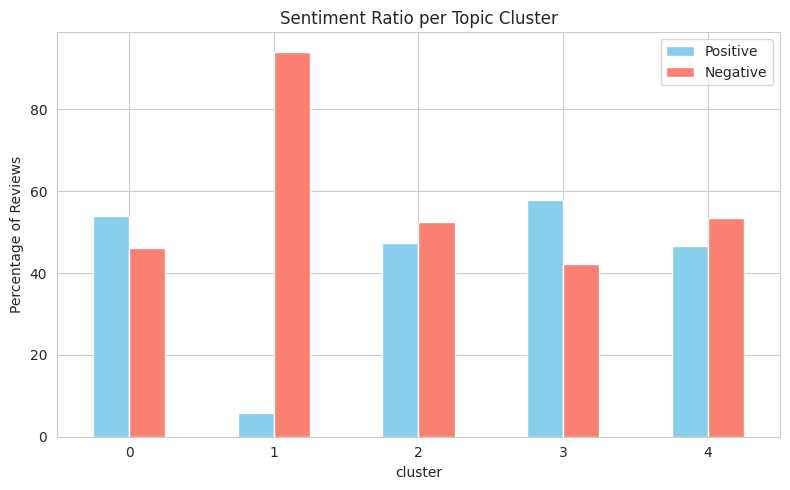

In [ ]:
#=========================11.5 Clustering in Topic Space=========================

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Apply KMeans on topic representation (W)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(W)

# Step 2: Build DataFrame with cluster + true sentiment
results_df = pd.DataFrame({
    'dominant_topic': np.argmax(W, axis=1),
    'cluster': clusters,
    'sentiment': y_train   # 1 = positive, 0 = negative
})

# Step 3: Compute sentiment distribution per cluster
cluster_sentiment = results_df.groupby('cluster')['sentiment'].agg([
    ('count', 'size'),
    ('positive_pct', lambda x: (x==1).mean()*100),
    ('negative_pct', lambda x: (x==0).mean()*100)
]).round(2)

print("Sentiment Distribution per Cluster:")
print(cluster_sentiment)

# Step 4: Visualize
cluster_sentiment[['positive_pct', 'negative_pct']].plot(
    kind='bar', stacked=False, figsize=(8,5),
    color=['skyblue', 'salmon']
)

plt.ylabel('Percentage of Reviews')
plt.title('Sentiment Ratio per Topic Cluster')
plt.xticks(rotation=0)
plt.legend(['Positive', 'Negative'])
plt.tight_layout()
plt.show()

## 11.6 Clustering Directly in TF-IDF Space (Stretch Comparison)

To evaluate whether dimensionality reduction via NMF improves cluster interpretability,
we now perform K-Means clustering directly in the original high-dimensional TF-IDF space.

We then compute sentiment ratios per cluster and compare them to clustering in topic space.

TF-IDF Space Clustering Sentiment Distribution:
         count  positive_pct  negative_pct
cluster                                   
0         3016         50.43         49.57
1         3036         37.68         62.32
2         8007         57.22         42.78
3         3865         37.57         62.43
4         7076         53.72         46.28


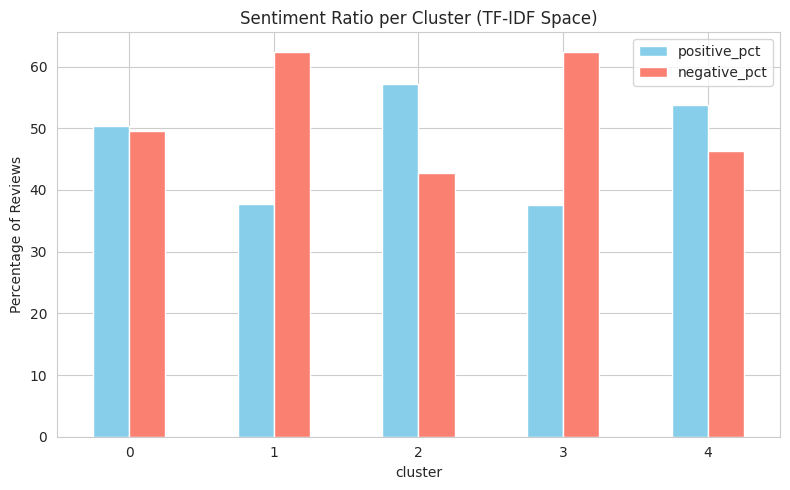

In [ ]:
# ========================= 11.6 Clustering in TF-IDF Space =========================

from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

kmeans_tfidf = KMeans(n_clusters=5, random_state=42)

# Apply KMeans on full TF-IDF matrix
clusters_tfidf = kmeans_tfidf.fit_predict(X_tfidf)

tfidf_cluster_df = pd.DataFrame({
    "cluster": clusters_tfidf,
    "sentiment": y_train
})

tfidf_cluster_summary = tfidf_cluster_df.groupby("cluster")["sentiment"].agg([
    ("count", "size"),
    ("positive_pct", lambda x: (x==1).mean()*100),
    ("negative_pct", lambda x: (x==0).mean()*100)
]).round(2)

print("TF-IDF Space Clustering Sentiment Distribution:")
print(tfidf_cluster_summary)

tfidf_cluster_summary[['positive_pct','negative_pct']].plot(
    kind='bar', figsize=(8,5), color=['skyblue','salmon']
)

plt.title("Sentiment Ratio per Cluster (TF-IDF Space)")
plt.ylabel("Percentage of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

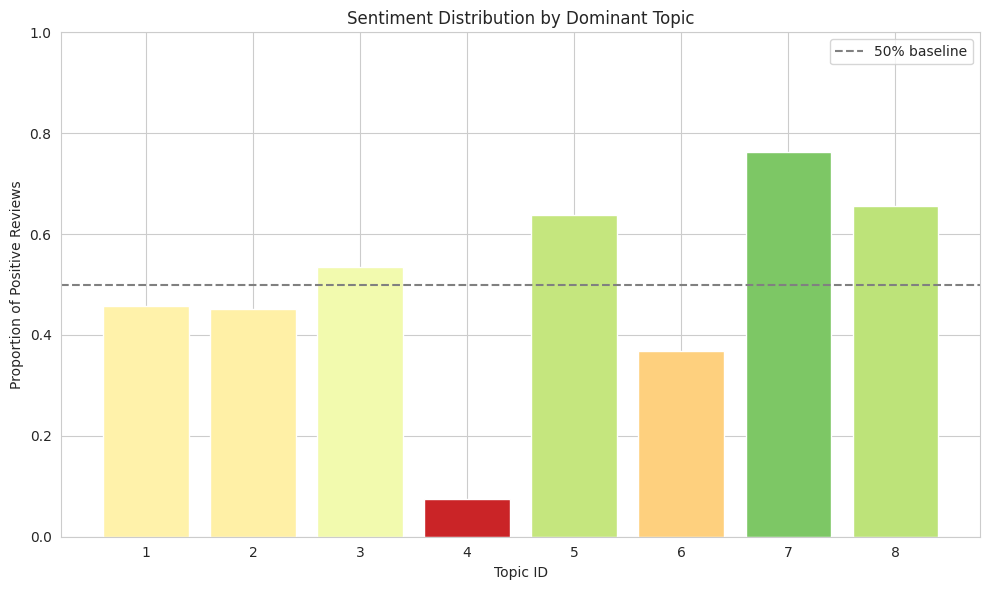

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assign dominant topic for each training review
dominant_topic_train = np.argmax(W, axis=1)

df_topics = pd.DataFrame({'topic': dominant_topic_train, 'label': y_train})

# Positive ratio per topic (ensure topics 0..7 appear in order)
pos_ratio_topic = df_topics.groupby('topic')['label'].mean().reindex(range(8))

plt.figure(figsize=(10,6))

colors = plt.cm.RdYlGn(pos_ratio_topic.values)  # values in [0,1]
plt.bar(range(1, 9), pos_ratio_topic.values, color=colors)

plt.axhline(0.5, color='gray', linestyle='--', label='50% baseline')
plt.xlabel('Topic ID')
plt.ylabel('Proportion of Positive Reviews')
plt.title('Sentiment Distribution by Dominant Topic')
plt.xticks(range(1, 9))
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig('figure5_topic_sentiment.pdf', dpi=300)
plt.show()

##**Comparison: Topic Space vs TF-IDF Space Clustering**

We compare clustering performed in NMF topic space with clustering performed directly in the high-dimensional TF-IDF space.

Clustering in topic space operates on the low-dimensional semantic representation provided by the document–topic matrix
𝑊
W. This representation captures latent thematic structure and compresses the original vocabulary into interpretable components. In contrast, clustering in TF-IDF space operates directly on very high-dimensional sparse vectors without semantic compression.

The results show that topic-space clustering produces stronger sentiment polarization. In particular, one cluster is overwhelmingly negative, while another cluster is clearly positive-dominant. By comparison, TF-IDF space clustering yields more mixed sentiment distributions, with most clusters exhibiting sentiment ratios closer to 50%.

This suggests that the NMF topic representation captures meaningful semantic structure that enhances clustering coherence and improves separation of sentiment-driven themes. Dimensionality reduction through topic modeling therefore contributes to more interpretable and sentiment-aligned clusters.

##**Cluster-Level Sentiment Analysis (Topic Space)**

To better understand how discovered topics relate to sentiment, we applied K-Means clustering in the NMF topic space and computed the proportion of positive reviews within each cluster.

The resulting clusters exhibit distinct sentiment compositions. One cluster is strongly negative-dominant, while another is clearly positive-dominant. The remaining clusters display more balanced sentiment distributions.

These findings demonstrate that thematic groupings derived from NMF are meaningfully aligned with sentiment polarity. While topics and sentiment are not identical, certain themes naturally correspond to positive or negative evaluations. Overall, this analysis confirms that NMF uncovers interpretable semantic structure that reflects underlying sentiment patterns in the dataset.